## Abstract

The Palmer Penguins dataset contains anatomical measurements for $344$ Penguins of $3$ different species and is commonly used when introducing students to new data science concepts.
In this blog post, we construct our first classification model in Python, attempting to accurately predict the species of a given observation in the Palmer Penguins dataset.
Constrained to one qualitative and two quantitative predictors, we create our model using the `scikit-learn` package's out-of-the-box logistic regression functionality.
We select features by conducting 5-fold cross-validation on logistic regression models constructed from every possible combination of one qualitative and two quantitative variables.
We implement our two models with the highest cross-validation score, selecting one that achieves 100% test data accuracy as our final model.

## Data Preparation

Most of the code in this section was conveniently provided by Professor Chodrow.

In [11]:
# Load packages 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import warnings

# Change pd display parameter
pd.set_option('display.max_colwidth', 100)

# Supress warnings to improve web aesthetics
warnings.filterwarnings("ignore")

# Load training data
train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

# Data preparation
train["Species"] = train["Species"].str.split().str.get(0)
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  x = df.drop(["Species"], axis = 1)
  x = pd.get_dummies(x)
  return x, y, df

X_train, y_train, viz_train = prepare_data(train)

## Data Exploration

Before constructing a classification model, it is often helpful to get a better feel for the data you are working with.
For this reason, we begin our analysis by creating and analyzing a few figures.

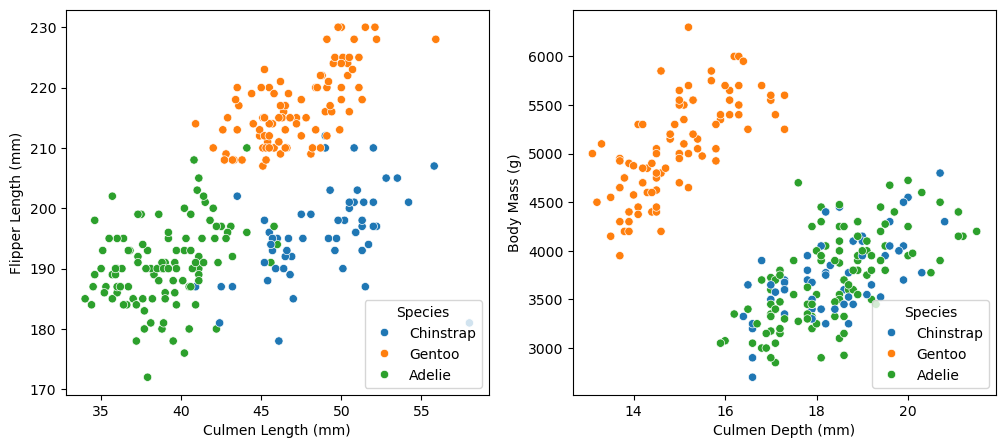

In [2]:
# Display plots
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

sns.scatterplot(viz_train, x = "Culmen Length (mm)", y = "Flipper Length (mm)", hue = "Species", ax = ax[0]);
sns.move_legend(ax[0], "lower right")
sns.scatterplot(viz_train, x = "Culmen Depth (mm)", y = "Body Mass (g)", hue = "Species", ax = ax[1]);
sns.move_legend(ax[1], "lower right")

In the first scatterplot, we have almost perfectly separated the three species of penguin using just two variables: flipper length and culmen length.
The Adelie penguins tend to have low values of both variables, the Chinstrap penguins tend to have large culmen lengths but small flipper lengths, and the Gentoo penguins tend to have medium culmen lengths and large flipper lengths.
One can imagine drawing straight lines in this graph that almost perfectly separate the three species of penguin.
The fact that we can visually distinguish between the different species of penguins makes me very confident about our prospects for classification.

In the second scatterplot, the Gentoo penguins tend to have small culmen depths and large body masses, separating them from the other two species with some white-space to spare.
However, the distributions of Adelie and Chinstrap points look almost identical, occupying the same lower right corner of the plot.
If our goal was simply to predict whether a penguin is a Gentoo penguin, then I would imagine that these two variables could help make a strong classifier.
However, since we seek to distinguish between all three species, these variables might not be the best choice.

While body mass (or body mass and culmen depth) alone is insufficient to distinguish between the species, perhaps accounting for a categorical variable like sex will reveal some patterns.
To explore this possibility, we include the following table of median body mass.

In [3]:
# Display table
viz_train.groupby(['Sex', 'Species'])[['Body Mass (g)']].median().unstack()

Body Mass (g)                  
Species        Adelie Chinstrap  Gentoo
Sex                                    
FEMALE         3350.0    3525.0  4700.0
MALE           4025.0    4050.0  5500.0

From this table, it is clear that the median body masses of all three species vary by sex, with the males tending to weigh more than the females.
Additionally, while we already knew from our scatterplot that the Gentoo penguins tend to weigh more than the other species, this table reinforces that conclusion and shows it to be true for both males and females.
Unfortunately, accounting for sex appears to do little to further distinguish between Adelie and Chinstrap penguins.
There is roughly a 200 gram difference between the median mass of female Adelie and Chinstrap penguins, so perhaps  sex in can help distinguish between the two species given that a penguin is female.
However, the median mass of male Adelie and Chinstrap penguins differs only by 25 grams.
A classifier would almost certainly need more information in order to make accurate predictions.

## Model Construction

Since the Palmer Penguins dataset is relatively small and we are given constraints on the number of features we may include in our model, we will select features by fitting a classifier for every possible combination of one qualitative and two quantitative variables.
There may be more robust and less computationally expensive methods of feature selection, but for our purposes, this works.

We implement logistic regression using `scikit-learn`'s out-of-the-box logistic-regression classifier.

In [4]:
# Choosing features
from itertools import combinations

# Distinguish between qualitative and quantitative variables
all_qual_cols = ['Clutch Completion', 'Sex', 'Island', 'Stage_Adult, 1 Egg Stage']
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

# Define classifier
LR = LogisticRegression(max_iter=100000000)

# Initialize dataframe to store data
models = pd.DataFrame(columns = ["CV Score", "Columns"])

# Find best-performing classifier
for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    cv_scores_LR = cross_val_score(LR, X_train[cols], y_train, cv = 5)
    cv_score = cv_scores_LR.mean()
    
    model = pd.DataFrame({"CV Score": [cv_score], "Columns": [cols]})

    models = pd.concat([models, model])


In [5]:
# Sort by CV Score and display best-performing models
models = models.sort_values("CV Score", ascending=False)
models.head()

,CV Score,Columns
0,0.988311,"[Island_Biscoe, Island_Dream, Island_Torgersen, Culmen Length (mm), Culmen Depth (mm)]"
0,0.988311,"[Sex_FEMALE, Sex_MALE, Culmen Length (mm), Culmen Depth (mm)]"
0,0.980543,"[Sex_FEMALE, Sex_MALE, Culmen Length (mm), Body Mass (g)]"
0,0.968854,"[Sex_FEMALE, Sex_MALE, Culmen Length (mm), Flipper Length (mm)]"
0,0.968778,"[Sex_FEMALE, Sex_MALE, Culmen Length (mm), Delta 13 C (o/oo)]"


Let's fit the model with the highest cross-validation score! There are actually two models with equal performance, so we will try both.

In [6]:
# Test the model

# Import data
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

# Adjust species label
test["Species"] = test["Species"].str.split().str.get(0)

# Data preparation
X_test, y_test, viz_test = prepare_data(test)

# Fit and output the performance of the model
model1 = LR.fit(X_train[models.iloc[[0]]['Columns'][0]], y_train)
model1_score = LR.score(X_test[models.iloc[[0]]['Columns'][0]], y_test)
model1_score

1.0

Voila! Logistic regression using the `Culmen Length (mm)`, `Culmen Depth (mm)`, and `Island` features correctly predicts every observation in our test data, achieving our goal.

In [7]:
# Test the next model
model2 = LR.fit(X_train[models.iloc[[1]]['Columns'][0]], y_train)
model2_score = LR.score(X_test[models.iloc[[1]]['Columns'][0]], y_test)
model2_score

0.9852941176470589

On the other hand, logistic regression using the Culmen Length (mm), Culmen Depth (mm), and Sex features does not achieve 100% accuracy on the test data.
Since our first model achieved 100% test accuracy, we select it as our final model.

## Model Evaluation

At this point, we have constructed a well-performing model, so we proceed to model evaluation.
First, we visualize our model's decision regions using the `plot_regions()` function provided by Professor Chodrow.

In [8]:
# Plotting decision regions function, generously provided by Professor Chodrow
def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (10, 4))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout(rect = (0,0,.95,.95))

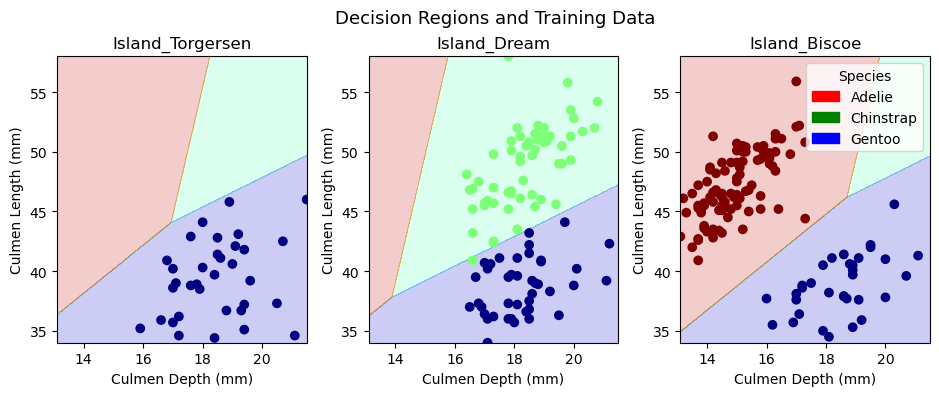

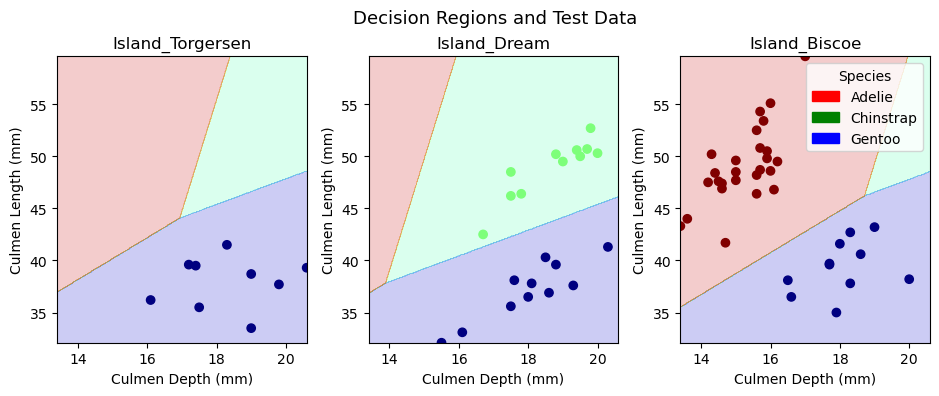

In [9]:
# Reverse the order of columns for the purposes of visualization
models.iloc[[0]]['Columns'][0].reverse()

# Refit model
LR.fit(X_train[models.iloc[[0]]['Columns'][0]], y_train)

# Plot decision regions on training data
plot_regions(LR, X_train[models.iloc[[0]]['Columns'][0]], y_train)
plt.suptitle("Decision Regions and Training Data", fontsize = 13)

# # Plot decision regions on test data
plot_regions(LR, X_test[models.iloc[[0]]['Columns'][0]], y_test)
plt.suptitle("Decision Regions and Test Data", fontsize = 13);

In the upper row of figures, we plot the training data in our decision regions, while in the lower row, we plot the test data in the decision regions.
We trained a model on our training data and implemented it on our test data, so the decision regions are identical in the two rows of figures.
The only difference between the rows is the points within the decision regions.
Since most observations are part of the training data, there are many more points in the first row of figures.
It is interesting to note that Torgersen Island only contains Gentoo penguins, Dream Island does not contain any Adelie penguins, and Biscoe Island does not contain any Chinstrap penguins.
These patterns makes it substantially easier to predict a given penguin's species.
One could imagine that the model would always predict Gentoo penguins on Torgersen Island.
Similarly, one could imagine the model never predicting Adelie penguins on Dream Island and never predicting Chinstrap penguins on Biscoe Island.
Interestingly, the model actually fits decision regions for all three penguin varieties in each island.
The decision region for a given species tends to be larger on islands where we would expect to find them, but the model allows for the possibility that there might be a penguin on an island where we would not expect one.
Overall, the logistic regression model does a great job of incorporating both qualitative and quantitative variables into its decision regions.

In [10]:
# Predict
model1_pred = model1.predict(X_test[models.iloc[[0]]['Columns'][0]])

# Confusion matrix
C = confusion_matrix(y_test, model1_pred)
C

array([[31,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 26]])

Since all of the predictions are on the main diagonal of the confusion matrix, we conclude that we did not misclassify any observations -- but we already knew this, since our model achieved 100% test accuracy!
If our model had not perfectly classified the observations in our test data, a confusion matrix would be more helpful for assessing our model's misclassification tendencies.

## Discussion

In this blog post, we began by exploring the Palmer Penguins dataset.
Our scatterplots and table illustrated that for some variables, there is substantial variation between different species of penguin, while for others, there is very little.
Determining which variables would be most valuable for classification required more than simple visualizations.
In order to robustly determine the best combination of one qualitative and two quantitative varibles, I fit a logistic regression model on every possible combination.
This process was relatively slow and may not work at scale, but it was successful in generating a highly accurate model in this scenario.
My final model used the `Culmen Length (mm)`, `Culmen Depth (mm)`, and `Island` features, achieving 100% accurate predictions on the test data.

This assignment furthered my understanding of the entire model-construction procedure, including data preparation, data exploration, feature selection, model fitting, and model evaluation.
After completing this blog post, I feel more confident about my ability to implement standard machine learning procedures from Python packages like `scikit-learn`.
While it is relatively easy to implement out-of-the-box classifiers from `scikit-learn`, it may be more difficult to understand their theoretical underpinnings.
As I finish this assignment, I am eager to learn more about the mathematics happening under the hood.